# Exploring consumer feedback and product ratings of amazon basics In-Ear headphones reviews

# Product selection

The product selected to this activity is a pair of Amazon Basics In-Ear Wired Headphones, Earbuds with Microphone, Black
byAmazon Basics found in Amazon in the following link:
https://www.amazon.ca/AmazonBasics-Ear-Headphones-Mic-Black/product-reviews/B07HH1QSLB/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews

# Data collection and organization

The selected technique for this part of the project was web scraping with slenium with the code below:

In [ ]:
import os
import time
import pandas as pd
import unicodedata
import html
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from langdetect import detect
from chromedriver_py import binary_path

# Setup the downloads directory
download_dir = r"C:\Users\brian\OneDrive\Documentos\Brianna\St Lawrence College\4 semester\operational analytics"
# Adjust this to your actual full downloads directory path
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Setup Selenium WebDriver
service = ChromeService(executable_path=binary_path)
options = webdriver.ChromeOptions()
options.add_experimental_option("prefs", {"download.default_directory": download_dir})
driver = webdriver.Chrome(service=service, options=options)

# List to store comments
comments = []

def clean_text(text):
    """
    This function cleans up the text by:
    - Unescaping HTML entities
    - Normalizing Unicode characters
    - Removing non-printable characters and special symbols
    - Replacing special punctuation like smart quotes and apostrophes
    """
    # Unescape HTML entities like &amp;, &quot;, etc.
    text = html.unescape(text)
    
    # Normalize Unicode to remove diacritics and other special combining marks
    text = unicodedata.normalize('NFKD', text)
    
    # Replace special quotes and apostrophes with standard ones
    replacements = {
        "’": "'",  # Smart apostrophe to regular apostrophe
        "“": '"',  # Left double quote to regular quote
        "”": '"',  # Right double quote to regular quote
        "–": "-",  # En dash to regular dash
        "—": "-",  # Em dash to regular dash
        "‘": "'",  # Left single quote to apostrophe
    }
    
    for orig, replacement in replacements.items():
        text = text.replace(orig, replacement)
    
    # Remove non-printable characters
    text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')
    
    # Return the cleaned text
    return text

def detect_captcha():
    #Check if the page has a CAPTCHA challenge and pause to allow manual solving
    try:
        captcha_element = driver.find_element(By.CSS_SELECTOR, "img[src*='captcha']")
        if captcha_element:
            print("CAPTCHA detected! Please solve the CAPTCHA manually.")
            input("Press Enter after solving the CAPTCHA to continue...")
    except NoSuchElementException:
        print("No CAPTCHA detected.")

def scrape_amazon_comments(url, total_comments=30):
    driver.get(url)
    time.sleep(2)  # Wait for the page to load

    detect_captcha()  # Check for CAPTCHA before starting

    while len(comments) < total_comments:
        # Check for CAPTCHA on each page
        detect_captcha()

        # Find all review elements on the page
        review_elements = driver.find_elements(By.CSS_SELECTOR, '.review-text-content span')
        review_dates = driver.find_elements(By.CSS_SELECTOR, '.review-date')  # Extract review dates
        review_stars = driver.find_elements(By.CSS_SELECTOR, '.review-rating span.a-icon-alt')  # Extract star ratings

        for i, review in enumerate(review_elements):
            if len(comments) >= total_comments:
                break
            comment_text = review.text.strip()
            review_date = review_dates[i].text  # Extract corresponding review date
            review_star = review_stars[i].get_attribute('textContent')  # Extract star rating

            # Detect language, process only English comments
            try:
                if detect(comment_text) == 'en':  # Check if the comment is in English
                    # Clean the text of special symbols and normalize it
                    cleaned_comment = clean_text(comment_text)
                    comments.append({
                        "Comment Number": len(comments) + 1,
                        "Date": review_date,
                        "Rating": review_star,
                        "Comment": cleaned_comment
                    })
                    print(f"Scraped and cleaned comment: {cleaned_comment} - Rating: {review_star}")
            except Exception as e:
                print(f"Error detecting language or cleaning comment: {e}")

        # Click the next page button, if available
        try:
            # Use an explicit wait to ensure the button is present
            next_button = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'li.a-last a')))
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(2)  # Wait for the new page to load
        except (NoSuchElementException, TimeoutException):
            print("No more pages or next button not found. Scraping complete.")
            break  # Exit if no more pages or the next button can't be found

    print(f"Total English comments scraped: {len(comments)}")
    return comments

# URL of the Amazon product review page
url = "https://www.amazon.ca/AmazonBasics-Ear-Headphones-Mic-Black/product-reviews/B07HH1QSLB/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"

# Start scraping comments
scraped_comments = scrape_amazon_comments(url, total_comments=30)

# Save the comments to a CSV file with improved formatting
df = pd.DataFrame(scraped_comments)
csv_path = os.path.join(download_dir, 'amazon_product_comments_with_ratings.csv')
df.to_csv(csv_path, index=False, columns=["Comment Number", "Date", "Rating", "Comment"])

# Close the browser
driver.quit()

print(f"Comments with ratings have been saved to {csv_path}")


The script is set up in a way that is ready to bypass CAPTCHA, if a CAPTCHA is found the execution of the script is stopped and the user is asked to solve the CAPTCHA on his own.

When it parses through all the reviews, the script captures the text of the comment, the date it was made and the stars it received, also reviews written in English are processed and the review text is stripped of all characters/symbols like [ # $ % @ * ( ) _ +..], so that the dataset is kind of clean and well organised for easy analysis. 

Once the number of reviews needed for analysis has been gathered, the information is exported down to a CSV file which contains the identification number, date of the review, the star rating, and, the cleaned comment section.

# Introduction

This notebook focuses on analyzing comments and ratings for a pair of Amazon Basics In-Ear Wired Headphones, and the main goal of it is to explore patterns in user feedback, including rating distribution, comment lengths, and other insights that can help identify key product characteristics.


# Data analysis and sentiment analysis

## Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk # Natural Languaje Tool Kit

# Load dataset and data overview

In [2]:
product_df = pd.read_csv('amazon_product_comments_with_ratings.csv', delimiter=',') # read csv file and create a pandas dataframa
product_df.shape # Check for shape 

(30, 4)

The dataset is conformed by 4 columns and 30 rows

In [3]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Comment Number  30 non-null     int64 
 1   Date            30 non-null     object
 2   Rating          30 non-null     object
 3   Comment         30 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.1+ KB


All columns have non-null values, so there are no missing entries in this dataset, and memory usage is approximately 1.1 KB, and two columns (`Date` and `Rating`) require conversions for better analysis.


In [4]:
product_df.head() # Check dataframe head

,Comment Number,Date,Rating,Comment
0,1,"Reviewed in Canada on September 2, 2024",5.0 out of 5 stars,Using thesr earphones with s9 phone and Samsun...
1,2,"Reviewed in Canada on September 10, 2024",3.0 out of 5 stars,These earbuds won't beat out the quality of la...
2,3,"Reviewed in Canada on September 2, 2024",5.0 out of 5 stars,The headphones look decent and well made. They...
3,4,"Reviewed in Canada on May 4, 2020",4.0 out of 5 stars,It was so comfortable for the ear
4,5,"Reviewed in Canada on May 28, 2021",5.0 out of 5 stars,I was satisfied with the quality of these head...


As we can see in the dataframe are different columns but for this project the relevant ones are raiting and comments because we want perform a sentiment analysis about the Amazon Basics In-Ear wired earphones

## Data preparation

In [5]:
product_df =  product_df[['Rating','Comment']].copy() # Copy dataframe with a limited number of columns
product_df.columns # Check new dataframe colum names

Index(['Rating', 'Comment'], dtype='object')

In this step, a new dataframe `product_df` is created by copying only two columns, `Rating` and `Comment`, from the original dataframe. This is useful when we want to work with a subset of the data that only contains relevant columns for analysis. 

### Cleaning

for the cleaning part the fisrt step is to convert to lowercases the comments and to integers the ratings

In [6]:
# converting to lowercase comments
product_df['Comment'] = product_df['Comment'].str.lower()
# Extract the numerical rating from the 'Rating' column
product_df['Rating'] = product_df['Rating'].str.extract('(\d+)').astype(int)

product_df.head()

,Rating,Comment
0,5,using thesr earphones with s9 phone and samsun...
1,3,these earbuds won't beat out the quality of la...
2,5,the headphones look decent and well made. they...
3,4,it was so comfortable for the ear
4,5,i was satisfied with the quality of these head...


then it is important to remove all punctuation from the column `Comment`

In [7]:
import string
translator =  str.maketrans('','',string.punctuation)
product_df['Comment'] = product_df['Comment'].str.translate(translator)

In this dataset, there are no missing values, however, in cases where missing values are present, a typical strategy would be to either impute them using the mean or median (for numerical data) or the most frequent category (for categorical data). Also, rows with missing values could be dropped if the missing data is minimal or insignificant to the analysis. 

In the case of duplicates, no duplicates were found but if they were present we can distort analysis results by overrepresenting certain data points. They would be identified using the `.duplicated()` method and removed with `.drop_duplicates()`

### Remove stop words

In [8]:
from nltk.corpus import stopwords

stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [9]:
product_df

,Rating,Comment
0,5,using thesr earphones with s9 phone and samsun...
1,3,these earbuds wont beat out the quality of lar...
2,5,the headphones look decent and well made they ...
3,4,it was so comfortable for the ear
4,5,i was satisfied with the quality of these head...
5,5,its pretty good overall audio qualitys great b...
6,3,impressed with these earphones i have been usi...
7,4,i was sent earbuds that dont work the left sou...
8,5,i was tired of buying expensive wireless ear b...
9,5,looks exactly like it does on the picture and ...


in this section, the `nltk` library is used to import English stopwords, which are common words like "the," "is," "in," etc., that usually do not contribute to the overall meaning of the comments, this step help us to prepare the data for the sentiment analysis.


# Stemming

in this part of the code is imported an initialized the `PorterStemmer` from `nltk`, a method on stemming English words, also a lambda function named func_stem is defined below which, applies the stemmer on all strings of Comment column.

The code then add a new column that is used to store these stemmed versions of the comments as ‘`ModifyComment`, to do this, the func_stem function is applied to the `ModifyComment` column; this makes a copy of each comment that is stemmed where words are reduced to a base form.

In [10]:
from nltk.stem.porter import PorterStemmer
port_stemer = PorterStemmer()

In [11]:
func_stem =  lambda x: ' '.join(port_stemer.stem(item) for item in x.split())

In [12]:
product_df['ModifyComment'] = product_df['Comment'].apply(func_stem)

In [13]:
product_df['ModifyComment'].apply(func_stem)

0     use thesr earphon with s9 phone and samsung ta...
1     these earbud wont beat out the qualiti of larg...
2     the headphon look decent and well made they ar...
3                          it wa so comfort for the ear
4     i wa satisfi with the qualiti of these headpho...
5     it pretti good over audio qualiti great but th...
6     impress with these earphon i have been use the...
7     i wa sent earbud that dont work the left sound...
8     i wa tire of buy expen wireless ear bud that s...
9     look exactli like it doe on the pictur and im ...
10    i order these by mistak end up give them to my...
11    cute and great for the kid but wont last more ...
12    the earphon work well and the sound is of good...
13    i bought these becau i want an earbud as small...
14        bon son bonn bass bon micro filspa trop cheap
15    need these for the gym treadmil veri happi purcha
16    i have had much troubl over the year find an e...
17    i discov im hard of hear after wake up one

In [14]:
product_df

,Rating,Comment,ModifyComment
0,5,using thesr earphones with s9 phone and samsun...,use thesr earphon with s9 phone and samsung ta...
1,3,these earbuds wont beat out the quality of lar...,these earbud wont beat out the qualiti of larg...
2,5,the headphones look decent and well made they ...,the headphon look decent and well made they ar...
3,4,it was so comfortable for the ear,it wa so comfort for the ear
4,5,i was satisfied with the quality of these head...,i wa satisfi with the qualiti of these headpho...
5,5,its pretty good overall audio qualitys great b...,it pretti good overal audio qualiti great but ...
6,3,impressed with these earphones i have been usi...,impress with these earphon i have been use the...
7,4,i was sent earbuds that dont work the left sou...,i wa sent earbud that dont work the left sound...
8,5,i was tired of buying expensive wireless ear b...,i wa tire of buy expens wireless ear bud that ...
9,5,looks exactly like it does on the picture and ...,look exactli like it doe on the pictur and im ...


## Sentiment analysis

In this section of the code, the `SentimentIntensityAnalyzer` from the `nltk` library is used to perform sentiment analysis on the stemmed comments. The analyzer helps determine the emotional tone of each comment by calculating the proportions of positive, negative, and neutral content. It also provides a compound score, which summarizes the overall sentiment on a scale from -1 (extremely negative) to 1 (extremely positive).

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [16]:
for index, row in product_df.iterrows():
    text = row['ModifyComment']         
    score = sia.polarity_scores(text) # calculate the polarity score  neg: pos: neu: compound:
    product_df.loc[index,['neg']]=score['neg']  # Create a neg colum if it does not exist and store negative score
    product_df.loc[index,['pos']]=score['pos']  # Create a pos colum... 
    product_df.loc[index,['neu']]=score['neu']  # create a new column  ..
    product_df.loc[index,['compound']]=score['compound']  # Create a compound column ..

In [17]:

product_df

,Rating,Comment,ModifyComment,neg,pos,neu,compound
0,5,using thesr earphones with s9 phone and samsun...,use thesr earphon with s9 phone and samsung ta...,0.000,0.265,0.735,0.9076
1,3,these earbuds wont beat out the quality of lar...,these earbud wont beat out the qualiti of larg...,0.036,0.142,0.822,0.8625
2,5,the headphones look decent and well made they ...,the headphon look decent and well made they ar...,0.121,0.045,0.834,-0.9161
3,4,it was so comfortable for the ear,it wa so comfort for the ear,0.000,0.351,0.649,0.5009
4,5,i was satisfied with the quality of these head...,i wa satisfi with the qualiti of these headpho...,0.094,0.000,0.906,-0.4215
5,5,its pretty good overall audio qualitys great b...,it pretti good overal audio qualiti great but ...,0.074,0.132,0.794,0.2500
6,3,impressed with these earphones i have been usi...,impress with these earphon i have been use the...,0.128,0.210,0.662,0.2746
7,4,i was sent earbuds that dont work the left sou...,i wa sent earbud that dont work the left sound...,0.130,0.051,0.819,-0.6670
8,5,i was tired of buying expensive wireless ear b...,i wa tire of buy expens wireless ear bud that ...,0.073,0.000,0.927,-0.2960
9,5,looks exactly like it does on the picture and ...,look exactli like it doe on the pictur and im ...,0.000,0.143,0.857,0.3612


Most of the comments have a neutral sentiment (`neu` values), reflecting that many reviews are descriptive without strong positive or negative language; however, there are clear distinctions between comments with higher `compound` scores, which indicate positive sentiment, and those with lower or negative `compound` scores, signaling dissatisfaction.

Positive comments, such as those praising the product's quality, feature high `compound` scores (e.g., 0.9076, 0.8625), and tend to have significant positive sentiment (`pos` values), on the other hand, negative comments often point to product flaws or issues and show lower `compound` scores (e.g., -0.9161, -0.6670), accompanied by higher `neg` values. 

The analysis shows that a considerable number of reviews are positive or neutral but there is some negative feedback contributing to knowledge about how to improve product quality.


## EDA

<Axes: xlabel='pos', ylabel='Count'>

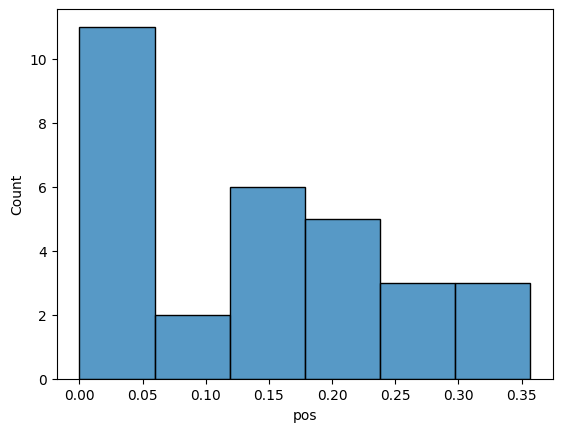

In [18]:
sns.histplot(data=product_df,x='pos')

This histogram shows the distribution of positive sentiment (`pos`) scores across the product reviews, most of the reviews have a `pos` score between 0.1 and 0.3, showing that the majority of comments express a moderately positive sentiment. 

Also, very few reviews show a high positive sentiment score above 0.3, and no reviews are extremely positive (above 0.4), so we can infer that while customers generally had positive experiences, they did not overwhelmingly express strong positivity in their feedback.

<Axes: xlabel='pos'>

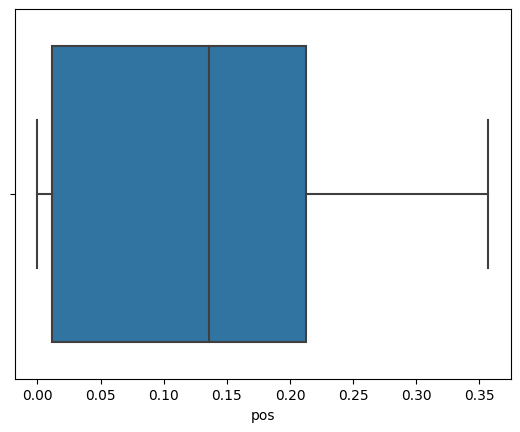

In [19]:
sns.boxplot(product_df,x='pos')


On the other hand we have this boxplot, which provides a more detailed look at the spread and distribution of the `pos` scores. The IQR range, representing the middle of the data, shows that most of the positive sentiment scores lie between 0.15 and 0.27, also the median positive sentiment score is around 0.2, which aligns with the histogram results, confirming that the majority of reviews are slightly positive but not extreme.

So with this plots we can infer that most reviews are positive but with restricitons, with a concentration of moderate sentiment rather than extreme positivity, so this could imply that while customers are generally satisfied, their comments are not overly enthusiastic, possibly indicating that the product meets expectations but doesn't significantly exceed them.

<Axes: xlabel='neg', ylabel='Count'>

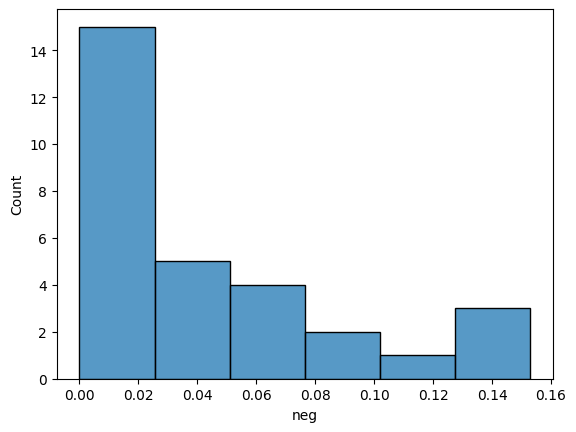

In [20]:
sns.histplot(product_df,x='neg')


The histogram shows the distribution of negative sentiment (`neg`) scores across the product reviews, most of the reviews have a `neg` score very close to 0, indicating that there is a very little negative sentiment in the majority of comments. 

Also a significant number of comments have a `neg` score of 0, and very few reviews have negative sentiment scores above 0.1, so this suggests us that customers rarely express strong negative feedback about the product, with most reviews being neutral or positive.

<Axes: xlabel='neg'>

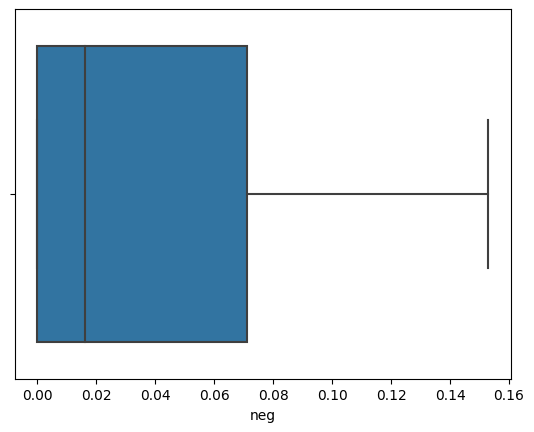

In [21]:
sns.boxplot(product_df,x='neg')

On the other hand we also have this boxplot that provides a more detailed look at the spread of negative sentiment scores, the IQR range shows that the middle of the data lies between 0.02 and 0.07, indicating that most comments have a minimal amount of negativity, it is to say that the majority of negative sentiment is mild, as reflected in the compact nature of the boxplot.


So this plots show us that negative sentiment in the reviews is generally low, with most customers not expressing significant dissatisfaction, this also aligns with the high ratings and positive sentiment found in the earlier analysis, indicating that the product meets customer expectations with few complaints or issues.


<Axes: xlabel='Rating', ylabel='count'>

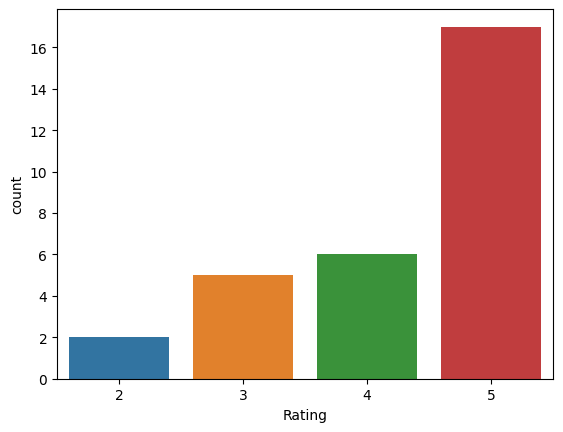

In [22]:
sns.countplot(product_df,x='Rating')

This plot shows the distribution of product ratings provided by the customers, it is to notice that the majority of the reviews have a rating of 5, which indicates high customer satisfaction with the product (a total of 17 reviews out of 30 have a 5-star rating)

The next most common rating is 4 stars, with around 6 reviews, followed by 3 stars with 5 reviews, only 2 reviews have a 2-star rating, and there are no 1-star ratings present in the dataset.

This suggests that customers are largely happy with their purchase, with very few instances of dissatisfaction (as indicated by the minimal 2-star ratings).


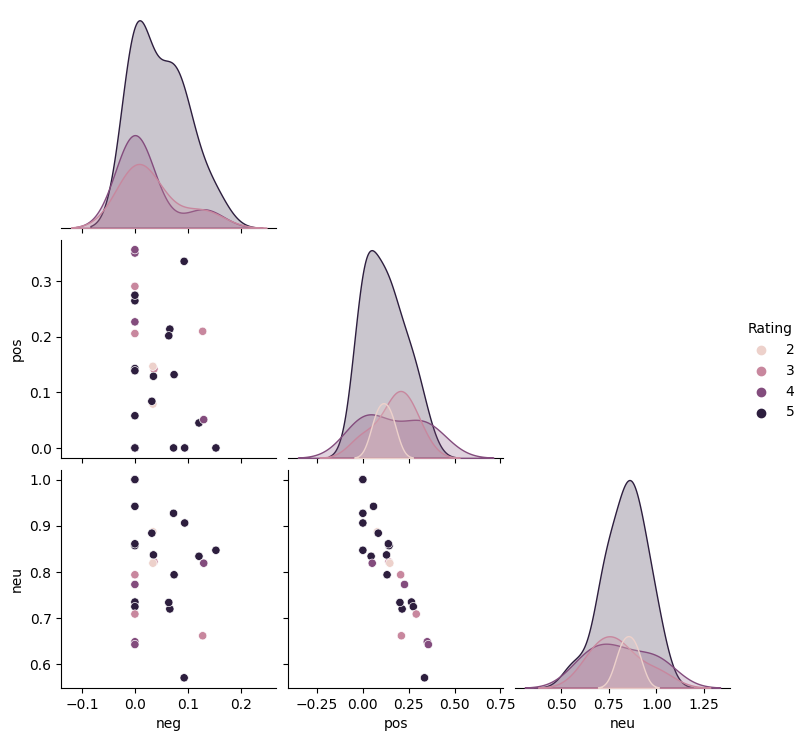

In [23]:
sns.pairplot(product_df[['Rating','neg','pos','neu']],corner=True,hue = 'Rating')

The pair plot shows us the relationships between the sentiment scores (`neg`, `pos`, `neu`) and the product ratings, with each point represents a specific review (reviews are colored according to their respective ratings, ranging from 2 to 5 stars)

Looking at the positive sentiment (`pos`) and its relationship with the `Rating`, we can observe a clear pattern: higher ratings (5 stars) tend to be associated with higher positive sentiment scores; most of the 5-star ratings are clustered in the higher `pos` score range, while lower-rated reviews (2 and 3 stars) tend to have lower `pos` scores, this confirms that reviews with higher ratings are generally more positive.

On the other hand, the negative sentiment (`neg`) scores are low across all ratings, also there is little variation in the `neg` scores, even for lower ratings, suggesting that reviews are more neutral or positive, with few customers expressing strong negative sentiments. 

The pair plot demonstrates that positive sentiment (`pos`) correlates with higher ratings, while negative sentiment (`neg`) remains consistently low regardless of the rating, and that neutral sentiment (`neu`) remains high across most ratings, especially for higher-rated reviews, which tend to have a balanced mix of positive and neutral content.


# Word cloud

In [120]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

In [121]:
all_reviews =  ' '.join(text for text in product_df['ModifyComment'])

tokens = word_tokenize(all_reviews)

def wcloud(txt):
    wordcloud = WordCloud(max_font_size=50,max_words=100,background_color='white').generate(txt)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

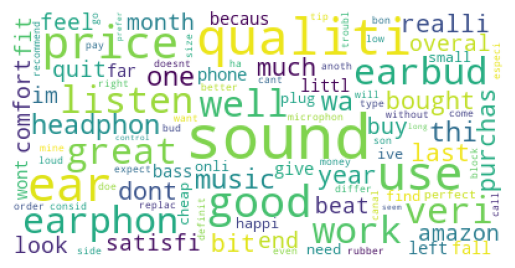

In [122]:
wcloud(all_reviews)

in this section, the reviews from the `ModifyComment` column are combined into a single string, which is then tokenized into individual words using the `word_tokenize()` function from `nltk`. This step help us to breaking down the text into components for analysis a better analysis, also a function to create the word cloud is defined to visualize the most frequent words in the whole reviews.


In [123]:
def clean_text(tokens, remove):
    clean_tokens = []
    for word in tokens:
        if word not in remove:
            clean_tokens.append(word)
    return clean_tokens

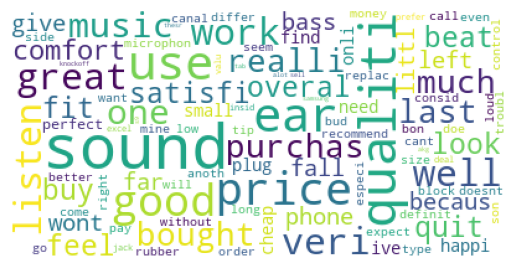

In [124]:
clean_tkns = clean_text(tokens, ['headphon', 'thi', 'earphon', 'earbud', 'wa', 'thi', 'i', 'amazon', 'end', 'year', 'bit', 'month', 'dont', 'ha', 'im'])

cleaned_reviews = ' '.join(clean_tkns)
wcloud(cleaned_reviews)

In this part of the code, the function `clean_text()` is defined to remove specific words from the list of tokens, this function iterates through each word in the tokenized text and appends it to the `clean_tokens` list only if it is not in the list of words to remove (such as 'headphon', 'thi', 'earphon', etc.).

After cleaning, the tokens are joined back together into a single string uto create a cleaned version of the reviews, the resulting word cloud provides a visualization of the most frequent words in the reviews, with the unwanted words successfully removed from the visualization.

From the cleaned text came a word cloud that underscores significant words like 'quality', 'sound', 'price', 'listen', and 'good' reflecting the worries and statements of customers, also terms such as 'quality' and 'sound' show that the products' functionality plays a vital role for customers, and with the word 'price' we can infer that consumers prioritize the cost effectiveness.

This approach with previous analyses reveals a clear story as we combine the sentiment distributions and scatterplots, because the results from the pair plot demonstrated that positive ratings are linked with high sentiment and the word cloud focuses on words like 'good', 'well', and 'great', and the reduced count of negative sentiment words in the word cloud and negative sentiment distribution correlates with the positive feedback shown in ratings.

The fusion of sentiment analysis and the word cloud indicates that customers frequently find the product satisfying with a main emphasis on sound quality and cost, and also show that customers generally enjoy a favorable experience with few negative sentiments.

# Collaborative Reflection

Throughout this assignment, our team worked to conduct a sentiment analysis of consumer reviews. 

In the data collection phase, we initially encountered issues with CAPTCHAs but to address this, we split the task between manual collection and scraping techniques with Selenium, this technique allowed us to speed up the process and ensure we gathered the necessary data effectively. 

Data cleaning was another key area where collaboration was crucial, our team worked to remove unnecessary elements such as punctuation, stopwords, and redundant characters, ensuring the text data was in optimal shape for analysis. 

In the sentiment analysis part, we worked to apply the NLTK Sentiment Scorer and analyze the results, each member contributed to refining the process, sharing observations that helped us ensure the accuracy of our sentiment scores. 

And finally, visualizing the data presented its own set of challenges, as it took several attempts to produce insightful and clear visualizations but together, we analyzed the emerging trends between sentiment and ratings, and adjusted the visual representations accordingly.

# Conclusion and Insights

The sentiment analysis provided valuable insights into consumer perceptions of the product, the analysis revealed that the majority of reviews carried a positive sentiment, indicating that most customers were satisfied with their purchase, also this reflects the product's overall success in meeting customer expectations.

When we looked at the correlation between ratings and sentiment, it became clear that higher ratings were associated with more positive sentiment, for example, reviews rated 4 or 5 stars consistently showed high positivity scores, suggesting that customers who were satisfied with the product wanted to express this with higher ratings.

On the other side, negative reviews were few but highly specific, these reviews typically pointed to distinct product flaws or issues, offering critical feedback that could guide improvements in the product and we truly believe that by addressing these concerns could further enhance the product and reduce dissatisfaction among future buyers.

Neutral sentiment was also present in a considerable number of reviews, and this indicates that while many customers were not overly enthusiastic, they were still satisfied, signaling that the product generally met their expectations without exceeding them.

From analisys carried out it could be noticed that most of the customers are satisfied with the product though a small porcentage of them seem to be unsatisfied; thus the next step would be to identify the proplem stated by the dissatisfied customer such that the business can work towards minimizing it with aim of improving the satisfaction level of its customers.


# Pareto analysis (most commonly mentioned characteristics)

for the firts Pareto analysis methodology we search the most commonly mentioned charactheristics, and the first step in tokenize the reviews and identify and extract the nouns

In [125]:
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd

nltk.download('averaged_perceptron_tagger')

# Combine all reviews into one string
all_reviews = ' '.join(text for text in product_df['ModifyComment'])

# Tokenize the reviews
tokens = word_tokenize(cleaned_reviews)

# Apply part-of-speech tagging
tokens = nltk.pos_tag(tokens)

# Create a DataFrame for nouns
nouns_df = pd.DataFrame(columns=['name'])

# Extract nouns from tokens
for word in tokens:
    if word[1] == 'NN':  
        nouns_df.loc[len(nouns_df.index)] = {'name': word[0]}
        

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


once we have our list of nouns, we move on to  analyze how frequently each noun appears in the customer reviews because this frequency analysis helps us pinpoint the key themes and attributes that customers mention the most

In [128]:
nouns_df.value_counts().nlargest(20)

name   
sound      16
price      11
qualiti    10
use         7
music       6
work        5
listen      3
ear         3
purchas     3
bass        3
comfort     3
veri        3
phone       3
tip         2
size        2
fit         2
jack        2
littl       2
happi       2
differ      2
dtype: int64

In [129]:
pareto_df =  nouns_df.value_counts().nlargest(20).rename_axis('characteristics').reset_index(name = 'count')

pareto_df.head()

,characteristics,count
0,sound,16
1,price,11
2,qualiti,10
3,use,7
4,music,6


 to maintain focus and clarity in our analysis, we focus on the top 20 nounshis allowing us to understand which product features dominate the customer feedback without getting overwhelmed by less frequent mentions, also we tally the frequency of each noun to see how often it appears across all reviews.

In [130]:
pareto_df['cumpec']=pareto_df['count'].cumsum()/pareto_df['count'].sum()*100

pareto_df

,characteristics,count,cumpec
0,sound,16,17.777778
1,price,11,30.000000
2,qualiti,10,41.111111
3,use,7,48.888889
4,music,6,55.555556
5,work,5,61.111111
6,listen,3,64.444444
7,ear,3,67.777778
8,purchas,3,71.111111
9,bass,3,74.444444


we also calculate the culminative percentage because this shows the running total of mentions as a percentage of all characteristics mentioned and help us to illustrate the Pareto principle — that a small number of causes (in this case, product features) can account for a large portion of the effect (here, customer feedback).

Also it is importatn to notice that the table starts with "sound" as the most frequently mentioned characteristic, cited 16 times, and this single feature constitutes approximately 17.78% of all mentions, underscoring its importance in customer discussions about the product; as we add more features like "price" and "quality," the cumulative percentage increases, indicating their collective significance, a good example of this is that by the time we account for the top three features — sound, price, and quality — they together represent about 41.11% of all mentions.

So this cumulative perspective is very important as it highlights the concentration of customer concerns or praises, and it shows that focusing on improving or emphasizing just a few key areas (like sound, price, and quality) could address the majority of customer feedback, aligning with the Pareto principle's assertion that 80% of effects come from 20% of causes.

In [131]:
from matplotlib.ticker import PercentFormatter

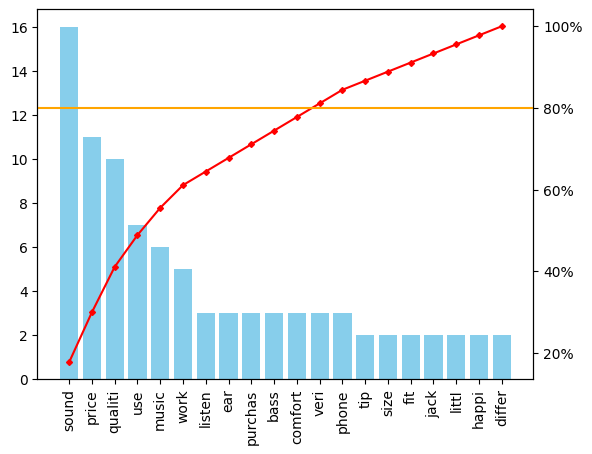

In [132]:
def pareto(data):
    fig,ax =  plt.subplots()
    ax.bar(pareto_df['characteristics'],pareto_df['count'], color='skyblue')
    plt.xticks(rotation=90)
    ax2=ax.twinx()  # Secondary ax
    ax2.plot(pareto_df['characteristics'],pareto_df['cumpec'],color = 'red', marker='D',ms=3)
    ax2.axhline(80,color='orange')
    ax2.yaxis.set_major_formatter(PercentFormatter())

pareto(pareto_df)

This chart analyzes customer feedback on product characteristics from reviews, identifying which features are most frequently mentioned and their cumulative influence on the discussion, so as we saw in the table also this chart starts with "sound" because it has the highest count, and as we move from left to right, characteristics like "price" and "quality" follow, each contributing to a growing cumulative percentage.

By the time we reach "music" and "work," the cumulative percentage increases more gradually, and each additional feature contributes less to the discussion, indicating they are of relatively lower concern or satisfaction among customers. ALso, as the line graph approaches and crosses the 80% threshold, it includes characteristics up to "phone", this suggests that focusing on the characteristics to the left of where the line crosses the orange line could potentially address the majority of customer concerns or interests.


So,  the characteristics that appear the line crosses the 80% threshold are the most crucial including aspects like sound quality, pricing, overall product quality, usability, and the listening experience, and we think that by addressing these key characteristics, the company that made this earphines can potentially improve customer satisfaction significantly, as these factors are evidently crucial to the customer experience.



# Sentiement based pareto analysis 

The purpose of this approach is to quantify and visualize the distribution and cumulative impact of the reviews sentiments by using the Pareto principle to highlight which sentiments are most prevalent and potentially most influential of the perception of the product.


In [1]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df_reviews = pd.read_csv('amazon_product_comments_with_ratings.csv')

# sentiment from text
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [3]:
# Apply the sentiment analysis function to the reviews
df_reviews['Sentiment'] = df_reviews['Comment'].apply(get_sentiment)

# Calculate the frequency of each sentiment type
sentiment_counts = df_reviews['Sentiment'].value_counts().sort_index()

# Calculate the cumulative percentage for Pareto analysis
cumulative_percentage = sentiment_counts.cumsum() / sentiment_counts.sum() * 100

In this case we use TextBlob library to make the sentimetn analysis process to calculate the polarity scores of each comment

<function matplotlib.pyplot.show(close=None, block=None)>

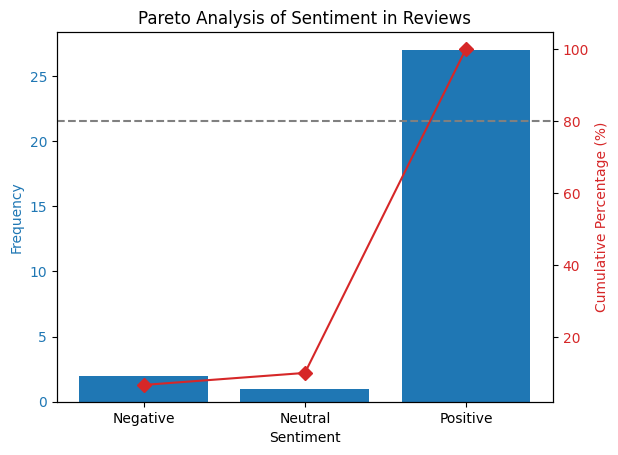

In [4]:
# bar plot for sentiment counts
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.bar(sentiment_counts.index, sentiment_counts, color=color)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Frequency', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# cumulative percentage
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(sentiment_counts.index, cumulative_percentage, color=color, marker='D', ms=7)
ax2.set_ylabel('Cumulative Percentage (%)', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=80, color='gray', linestyle='--')  

plt.title('Pareto Analysis of Sentiment in Reviews')
plt.show


This chart helps to correlate sentiments negative, neutral, and positive with the overall customer feedback and shows us the contribution of each of them, also the bar most concerned is positive that outperforms the other two bars which are neutral and negative sentiments. 

If we analyse the red line (cumulative percentage of reviews) it shoots almost immediately after taking into consideration positive sentiments and gets close to 100 very quickly, this rapid increase states that positive reviews closely to a degree approximate the sentiment of the customer base, and when we analyze the countration of the reviews, one can immediately follow the Pareto diagram with 80% of loaded information falling under the positive category; this means than concentrating only on positive reviews can help in comprehending more or less all the customer's preferences.

Another interesting thing that we observed is that the number of neutral and negative comments are even less, hinting at the fact that areas which may be dissatisfying for customers are limited at the most or may not even be reported at all; this distribution raises a question of whether the positive reviews might actually obscure more infrequent, but perhaps more valuable critical feedback, and as a conclusion we think that this earphones producers should not only take pride in achieving success but also focus on the actually few, though significant, complaints that may have been expressed.

# Raitings based pareto analysis

In this approach we categorize customer ratings into different levels of satisfaction and employs the Pareto principle to prioritize areas that significantly affect customer perceptions.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('amazon_product_comments_with_ratings.csv')


In [14]:

# Extracting the numeric part of the rating string
df['Rating'] = df['Rating'].str.extract('(\d+\.\d+|\d+)').astype(float)

In [15]:
def classify_rating(rating):
    if rating >= 4:
        return 'High Satisfaction'
    elif rating >= 3:
        return 'Moderate Satisfaction'
    elif rating >= 2:
        return 'Low Satisfaction'
    else:
        return 'Dissatisfaction'

# classification
df['Satisfaction_Level'] = df['Rating'].apply(classify_rating)


we started by extracting and cleaning the data to ensure that the ratings are in a numeric format and then we classify each rating into one of four categories (high satisfaction, moderate sactisfaction, low satisfaction, and dissasctisfaction)

In [16]:
rating_counts = df['Satisfaction_Level'].value_counts()

# Sort the categories 
rating_counts = rating_counts.sort_index()

cumulative_percentage = rating_counts.cumsum() / rating_counts.sum() * 100



then we calculate the frequency of each satisfaction level, which will show the distribution of customer sentiments across the product range.

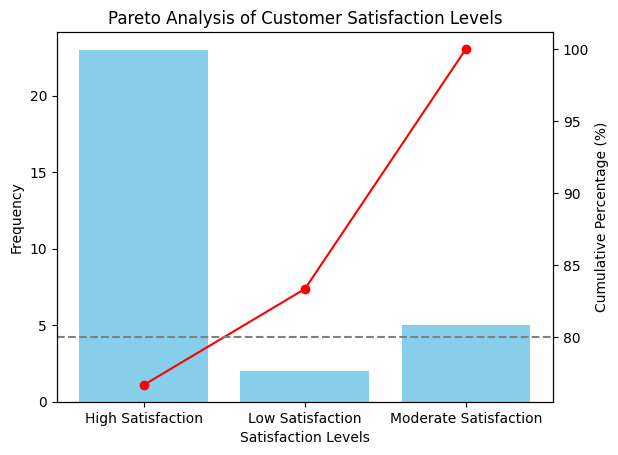

In [17]:
fig, ax1 = plt.subplots()

# Bar chart for frequencies
ax1.bar(rating_counts.index, rating_counts, color='skyblue')
ax1.set_xlabel('Satisfaction Levels')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='y')

# cumulative percentage
ax2 = ax1.twinx()
ax2.plot(rating_counts.index, cumulative_percentage, color='red', marker='o')
ax2.set_ylabel('Cumulative Percentage (%)')
ax2.axhline(y=80, color='gray', linestyle='--')  

plt.title('Pareto Analysis of Customer Satisfaction Levels')
plt.show()


It is evident from the above plot that there is massive positivity as most of the customers’ ratings are extremely high, because the cumulative percentage line touches the 80 % mark at the boundary between high satisfaction and moderately satisfied and therefore increasing satisfaction features which currently moderately satisfied clients enjoy could make them shift to this category we classify as highly satisfied clients.

We think that by targeting to turn ‘satisfied’ customers into ‘highly satisfied’, the company may increase the level of customers’ delight, which will always positively affect brand and product perceptions, also this type of analysis assists in identifying and prioritizing areas requiring enhancement of product improvements but also in the creation of a strategic plan to optimise customer satisfaction based on actual information.

# Result comparisions

In this assignment we have used three different types of Pareto analysis (the first one saw in class and two other different) to analyze the customer feedbacks in a different way. The first method displays the most frequently mentioned product characteristics in the customer review, such as ‘sound’, ‘price’, ‘quality’ etc and thus gives a picture of which all aspects customers discuss the most, the second divides customer satisfaction by rating level, where high, moderate or low level of satisfaction is defined, and the third analysis examines the comments in terms of the positive or negative emotion evidenced in reviews depending on whether the comment is positive, negative or neutral.

By comparing these different methodologies, it is a constant result, positive aspects are found to dominate the customer feedback, however, while the ratings and analyse give us rough classifications of how customers feel, the characteristics analyse offers more concrete focus on certain aspects of the product.

The performance of these three methodologies shows the depth and breadth of knowledge that each can provide, the first feature-based approach allows you to take actions that will be beneficial for product development and improvement in relation to those key features such as sound and quality, meanwhile, the sentiment and ratings methods provide an overview of customer satisfaction that reveals high-level trends, but do not delve into the details of each product attribute, however, the important thing is to analyze both in order to have a better understanding of what needs to be done for the customer's needs.

It is to say that this methods are not just an easy way to spotlight the things customers like, but its ability to tell us which features are mentioned the most allows us to identify where opportunities for improvement lie.


# Characteristics in need of attention

Analysis of these areas indicates which are key areas of focused improvement that will greatly increase customer satisfaction; it is to notice customer perception of sound quality as a critical driver becomes the star of the show, repeatedly rated a 5-star in positive reviews, yet still powerful enough to suggest that even small improvements would be noticeable, much the same, "price" and "quality" are often metioned by customers together, referring to the fact that the two aspects combined form a great part of how customers decide whether a product or service is a good buy and their perception of value, and also phone functionality is another worth mentioning, though mentioned less often, area, which if improved could improve product satisfaction.

# Suggested processes and departments

we think that the product development team should focus even more on optimizing the sound quality and adding new features that match customer expectations or needs, particularly, improving phone features, also, for the quality assurance department, the current product must conform not only to high quality required at the price niche, but also guarantee consistent investments in the testing and feedback system to address possible problems beforehand. On the other hand, customer service and the marketing departments’ should capital on the overwhelmingly positive feedback for promotional use while seeing to it that all the complains and or suggestions are well attended to appropriately. 

In this case, the application of customer feedback analysis indicates that the company can consolidate its efforts on these areas that are strategic to increase value for customers; this is because these are specific parts of the product that customers care most about and this not only optimise the effect of improvement on current customer satisfaction but does tie up with the Pareto principle that states that the main effects often come from a few key causes.

We truly believe that by making those improvements on that departments this enterprise not only will improving this erphones quality, it also will communicate what they’ve improved to customers so that they will be happy and as a consecuence the will stay loyal.
